In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eye-diseases-classification/dataset/glaucoma/1255_right.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/1482_left.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_398_8823411.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_309_4110303.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_13_697490.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_205_310538.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/Glaucoma_040.png
/kaggle/input/eye-diseases-classification/dataset/glaucoma/1256_right.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_221_3079640.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_392_9636183.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_12_5295071.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_399_7128170.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_113_8738972.jpg
/kaggle/input/eye-disea

**DieT(tiny)**

Epoch 1/10 - Loss: 0.4339 - Acc: 83.55%
Epoch 2/10 - Loss: 0.2534 - Acc: 90.51%
Epoch 3/10 - Loss: 0.2017 - Acc: 92.71%
Epoch 4/10 - Loss: 0.1477 - Acc: 94.84%
Epoch 5/10 - Loss: 0.1219 - Acc: 95.61%
Epoch 6/10 - Loss: 0.0906 - Acc: 96.71%
Epoch 7/10 - Loss: 0.0783 - Acc: 97.39%
Epoch 8/10 - Loss: 0.0737 - Acc: 97.24%
Epoch 9/10 - Loss: 0.0692 - Acc: 97.63%
Epoch 10/10 - Loss: 0.0407 - Acc: 98.58%
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.87      0.97      0.92       202
diabetic_retinopathy       1.00      1.00      1.00       216
            glaucoma       0.89      0.79      0.84       215
              normal       0.85      0.84      0.85       211

            accuracy                           0.90       844
           macro avg       0.90      0.90      0.90       844
        weighted avg       0.90      0.90      0.90       844



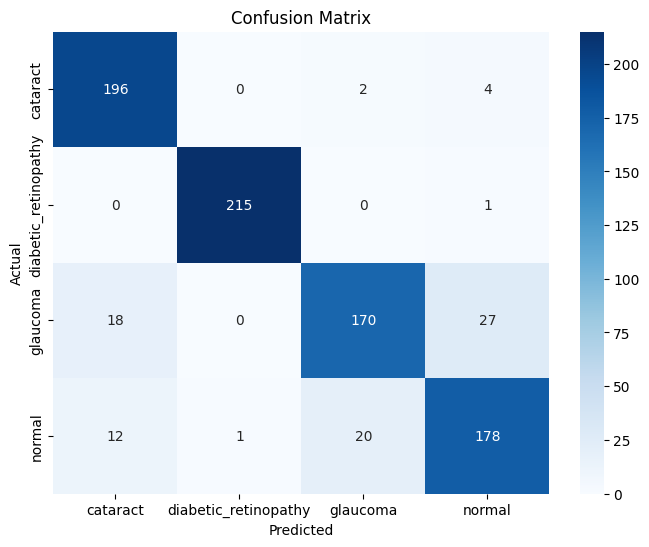

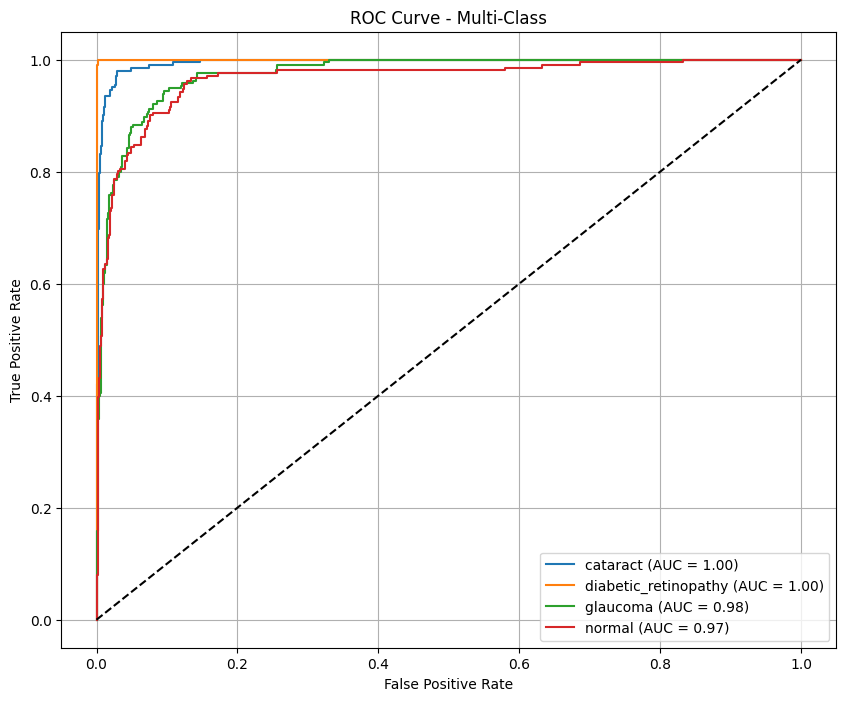

Predicted Class: cataract
No attention maps were extracted.


In [3]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load DeiT Tiny Model
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names))
model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Function
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.4f} - Acc: {100 * correct / total:.2f}%")

train_model(model, train_loader, val_loader, epochs=10)

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
# Binarize labels for ROC-AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

# Predict single image
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

# Example prediction
test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Attention Map Visualization for DeiT
attention_maps = []

def hook_attention(module, input, output):
    if isinstance(output, tuple):
        output = output[0]
    attention_maps.append(output.detach().cpu())

# Register hooks to transformer attention layers
for name, module in model.named_modules():
    if 'attn_drop' in name:
        module.register_forward_hook(hook_attention)

def visualize_attention(image_path):
    attention_maps.clear()
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        _ = model(img_tensor)

    if attention_maps:
        attn_map = attention_maps[-1].squeeze(0)
        num_heads = attn_map.shape[0]

        fig, axes = plt.subplots(1, num_heads, figsize=(15, 5))
        for i in range(num_heads):
            ax = axes[i]
            attn = attn_map[i].mean(dim=0).reshape(7, 7)
            ax.imshow(attn, cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Head {i+1}')
        plt.suptitle('Attention Maps (last layer)', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("No attention maps were extracted.")

# Example usage for attention visualization
visualize_attention(test_image_path)

Epoch 1/10 - Train Loss: 0.4614 - Train Acc: 82.09% - Val Loss: 0.2521 - Val Acc: 91.11%
Epoch 2/10 - Train Loss: 0.2859 - Train Acc: 89.21% - Val Loss: 0.3162 - Val Acc: 89.69%
Epoch 3/10 - Train Loss: 0.2146 - Train Acc: 92.08% - Val Loss: 0.2143 - Val Acc: 91.23%
Epoch 4/10 - Train Loss: 0.2065 - Train Acc: 92.11% - Val Loss: 0.1763 - Val Acc: 92.42%
Epoch 5/10 - Train Loss: 0.1859 - Train Acc: 92.80% - Val Loss: 0.2044 - Val Acc: 92.54%
Epoch 6/10 - Train Loss: 0.1620 - Train Acc: 94.10% - Val Loss: 0.2003 - Val Acc: 93.13%
Epoch 7/10 - Train Loss: 0.1411 - Train Acc: 95.02% - Val Loss: 0.1733 - Val Acc: 92.65%
Epoch 8/10 - Train Loss: 0.1312 - Train Acc: 95.14% - Val Loss: 0.2018 - Val Acc: 92.65%
Epoch 9/10 - Train Loss: 0.1211 - Train Acc: 94.96% - Val Loss: 0.2520 - Val Acc: 91.23%
Epoch 10/10 - Train Loss: 0.1199 - Train Acc: 95.61% - Val Loss: 0.1859 - Val Acc: 92.18%


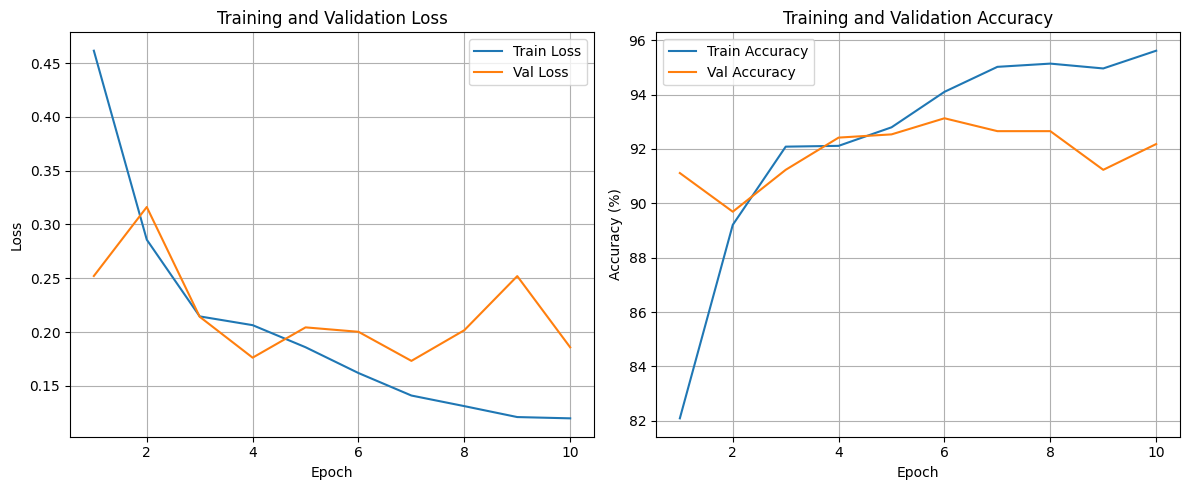


Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.93      0.94      0.94       189
diabetic_retinopathy       1.00      1.00      1.00       235
            glaucoma       0.85      0.89      0.87       199
              normal       0.92      0.87      0.90       221

            accuracy                           0.93       844
           macro avg       0.93      0.93      0.93       844
        weighted avg       0.93      0.93      0.93       844



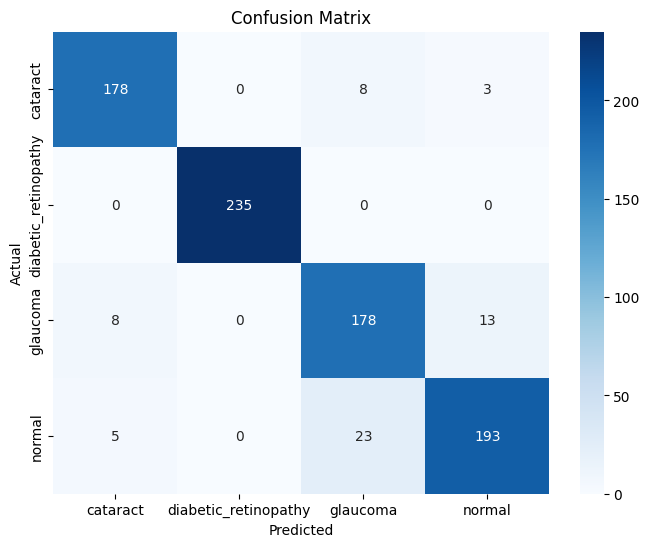

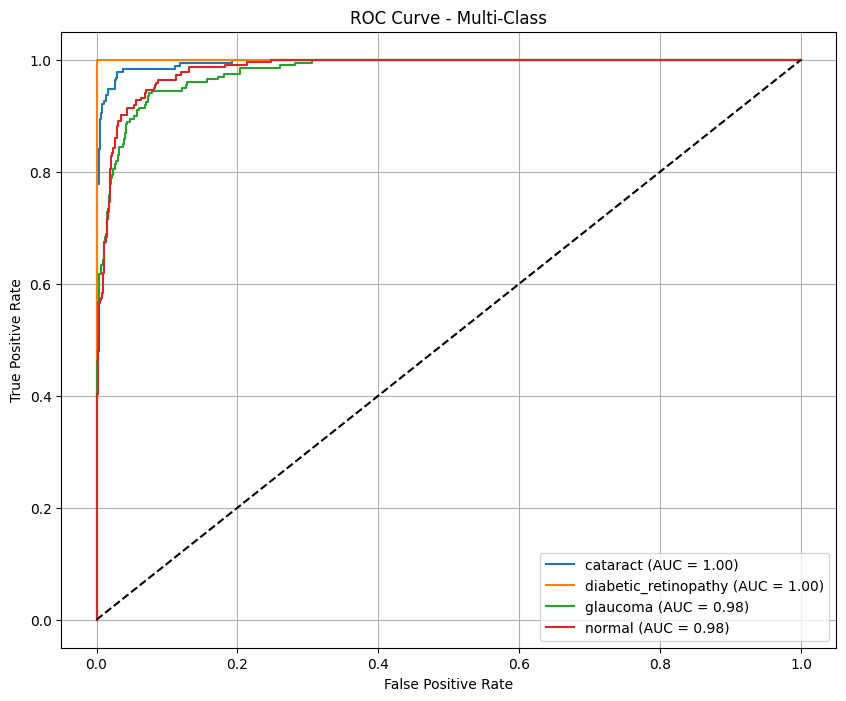

Predicted Class: cataract

=== Final Results ===
Final Training Accuracy: 95.61%
Final Validation Accuracy: 92.18%
Test Accuracy: 92.89%
Final AUC Score (Training+Validation): 0.9898
Test AUC Score: 0.9898

Class-wise AUC Scores:
cataract: 0.9957
diabetic_retinopathy: 1.0000
glaucoma: 0.9795
normal: 0.9840

Confusion Matrix:
 [[178   0   8   3]
 [  0 235   0   0]
 [  8   0 178  13]
 [  5   0  23 193]]

Classification Report (Test Set):
 {'cataract': {'precision': 0.9319371727748691, 'recall': 0.9417989417989417, 'f1-score': 0.9368421052631578, 'support': 189}, 'diabetic_retinopathy': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 235}, 'glaucoma': {'precision': 0.8516746411483254, 'recall': 0.8944723618090452, 'f1-score': 0.8725490196078433, 'support': 199}, 'normal': {'precision': 0.9234449760765551, 'recall': 0.8733031674208145, 'f1-score': 0.8976744186046512, 'support': 221}, 'accuracy': 0.9289099526066351, 'macro avg': {'precision': 0.9267641974999373, 'recall': 0.92

In [4]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Image transformations (Updated to ImageNet stats)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Augmentation to reduce overfitting
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load DeiT Tiny Model
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names))
model.to(device)

# Loss & Optimizer (Added weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Lists to store metrics
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Training Function with Validation
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        # Training Phase
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation Phase
        model.eval()
        val_correct, val_total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_epoch_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, epochs=10)

# Plot Training and Validation Metrics
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation on Validation Set (Proxy for Test Set)
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
test_acc = accuracy_score(y_true, y_pred) * 100  # Using validation as test set proxy

# Classification Report
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve and AUC Score
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

# Final AUC (macro average)
final_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
test_auc = final_auc  # Using validation as test set proxy

# Predict single image
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

# Example prediction
test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Final Results Summary for Research Paper
print("\n=== Final Results ===")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final AUC Score (Training+Validation): {final_auc:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClass-wise AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names, output_dict=True))

Epoch 1/20 - Train Loss: 0.5556 - Train Acc: 79.07% - Val Loss: 0.4005 - Val Acc: 86.49%
Epoch 2/20 - Train Loss: 0.3306 - Train Acc: 88.38% - Val Loss: 0.2935 - Val Acc: 88.27%
Epoch 3/20 - Train Loss: 0.2955 - Train Acc: 89.27% - Val Loss: 0.3276 - Val Acc: 87.68%
Epoch 4/20 - Train Loss: 0.2514 - Train Acc: 90.87% - Val Loss: 0.2862 - Val Acc: 89.57%
Epoch 5/20 - Train Loss: 0.2284 - Train Acc: 91.79% - Val Loss: 0.3968 - Val Acc: 86.61%
Epoch 6/20 - Train Loss: 0.2137 - Train Acc: 92.29% - Val Loss: 0.2723 - Val Acc: 89.93%
Epoch 7/20 - Train Loss: 0.1904 - Train Acc: 93.12% - Val Loss: 0.2567 - Val Acc: 90.05%
Epoch 8/20 - Train Loss: 0.1754 - Train Acc: 93.42% - Val Loss: 0.2127 - Val Acc: 92.18%
Epoch 9/20 - Train Loss: 0.1832 - Train Acc: 93.36% - Val Loss: 0.2775 - Val Acc: 89.34%
Epoch 10/20 - Train Loss: 0.1830 - Train Acc: 93.33% - Val Loss: 0.1896 - Val Acc: 92.65%
Epoch 11/20 - Train Loss: 0.1463 - Train Acc: 94.63% - Val Loss: 0.1956 - Val Acc: 93.13%
Epoch 12/20 - Train

<ipython-input-5-e61b8c92dc5e>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


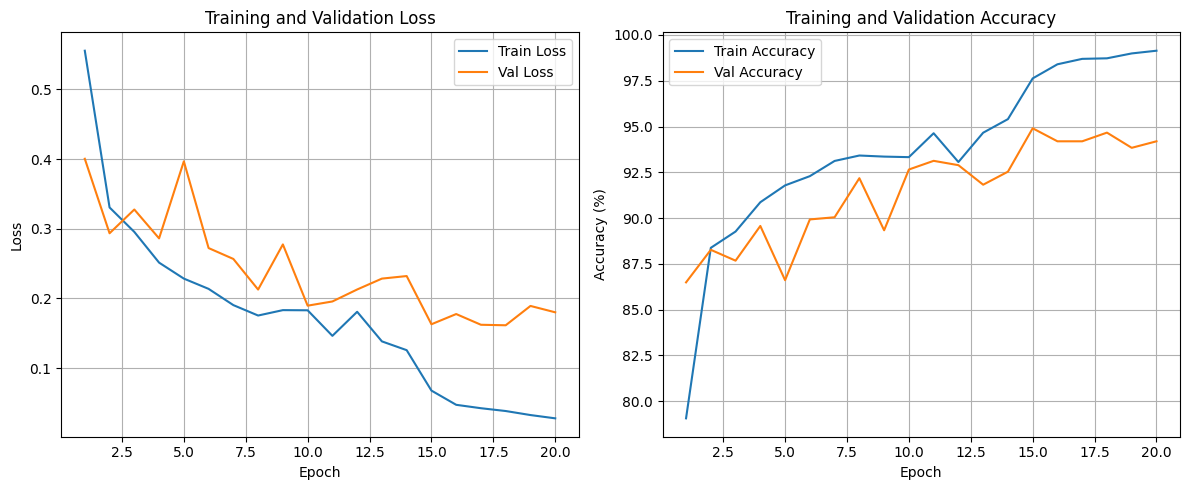


Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.99      0.96      0.97       212
diabetic_retinopathy       1.00      1.00      1.00       225
            glaucoma       0.92      0.90      0.91       210
              normal       0.88      0.93      0.91       197

            accuracy                           0.95       844
           macro avg       0.95      0.95      0.95       844
        weighted avg       0.95      0.95      0.95       844



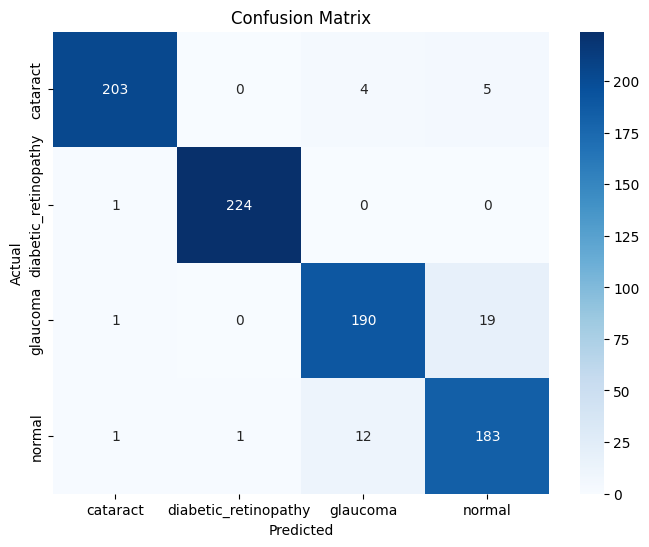

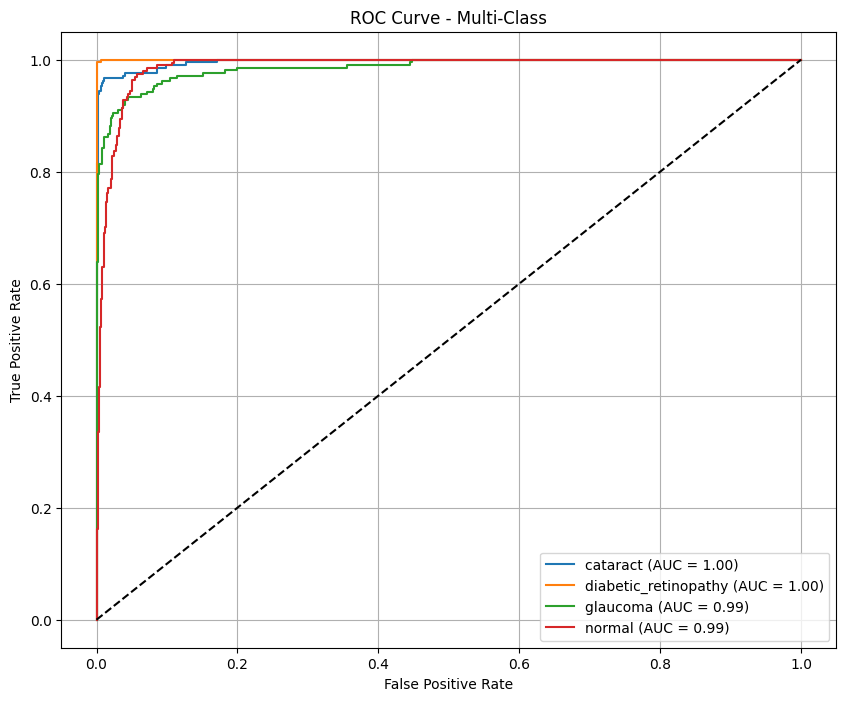

Predicted Class: cataract

=== Final Results ===
Final Training Accuracy: 99.14%
Final Validation Accuracy: 94.19%
Test Accuracy: 94.79%
Final AUC Score (Training+Validation): 0.9924
Test AUC Score: 0.9924

Class-wise AUC Scores:
cataract: 0.9966
diabetic_retinopathy: 1.0000
glaucoma: 0.9855
normal: 0.9874

Confusion Matrix:
 [[203   0   4   5]
 [  1 224   0   0]
 [  1   0 190  19]
 [  1   1  12 183]]

Classification Report (Test Set):
 {'cataract': {'precision': 0.9854368932038835, 'recall': 0.9575471698113207, 'f1-score': 0.9712918660287081, 'support': 212}, 'diabetic_retinopathy': {'precision': 0.9955555555555555, 'recall': 0.9955555555555555, 'f1-score': 0.9955555555555555, 'support': 225}, 'glaucoma': {'precision': 0.9223300970873787, 'recall': 0.9047619047619048, 'f1-score': 0.9134615384615385, 'support': 210}, 'normal': {'precision': 0.8840579710144928, 'recall': 0.9289340101522843, 'f1-score': 0.905940594059406, 'support': 197}, 'accuracy': 0.9478672985781991, 'macro avg': {'pr

In [5]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Stronger Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load DeiT Tiny Model with Dropout
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names), drop_rate=0.1)
model.to(device)

# Loss & Optimizer with Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Metrics
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training with Early Stopping
def train_model(model, train_loader, val_loader, epochs=20, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        # Training
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_correct, val_total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_epoch_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        
        # Scheduler and Early Stopping
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train
train_model(model, train_loader, val_loader, epochs=20, patience=5)

# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
test_acc = accuracy_score(y_true, y_pred) * 100
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

final_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
test_auc = final_auc

# Single Image Prediction
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Final Results
print("\n=== Final Results ===")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final AUC Score (Training+Validation): {final_auc:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClass-wise AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names, output_dict=True))

Epoch 1/50 - Train Loss: 0.4856 - Train Acc: 81.11% - Val Loss: 0.3823 - Val Acc: 87.56%
Epoch 2/50 - Train Loss: 0.3258 - Train Acc: 88.88% - Val Loss: 0.4307 - Val Acc: 85.43%
Epoch 3/50 - Train Loss: 0.2862 - Train Acc: 89.86% - Val Loss: 0.2789 - Val Acc: 89.69%
Epoch 4/50 - Train Loss: 0.2215 - Train Acc: 91.28% - Val Loss: 0.3351 - Val Acc: 87.44%
Epoch 5/50 - Train Loss: 0.2158 - Train Acc: 92.65% - Val Loss: 0.3166 - Val Acc: 89.22%
Epoch 6/50 - Train Loss: 0.2020 - Train Acc: 93.45% - Val Loss: 0.2494 - Val Acc: 89.69%
Epoch 7/50 - Train Loss: 0.1855 - Train Acc: 93.06% - Val Loss: 0.2589 - Val Acc: 91.47%
Epoch 8/50 - Train Loss: 0.1794 - Train Acc: 93.51% - Val Loss: 0.3173 - Val Acc: 88.51%
Epoch 9/50 - Train Loss: 0.1564 - Train Acc: 93.95% - Val Loss: 0.2153 - Val Acc: 92.54%
Epoch 10/50 - Train Loss: 0.1485 - Train Acc: 94.49% - Val Loss: 0.2239 - Val Acc: 92.42%
Epoch 11/50 - Train Loss: 0.1603 - Train Acc: 94.10% - Val Loss: 0.2188 - Val Acc: 92.77%
Epoch 12/50 - Train

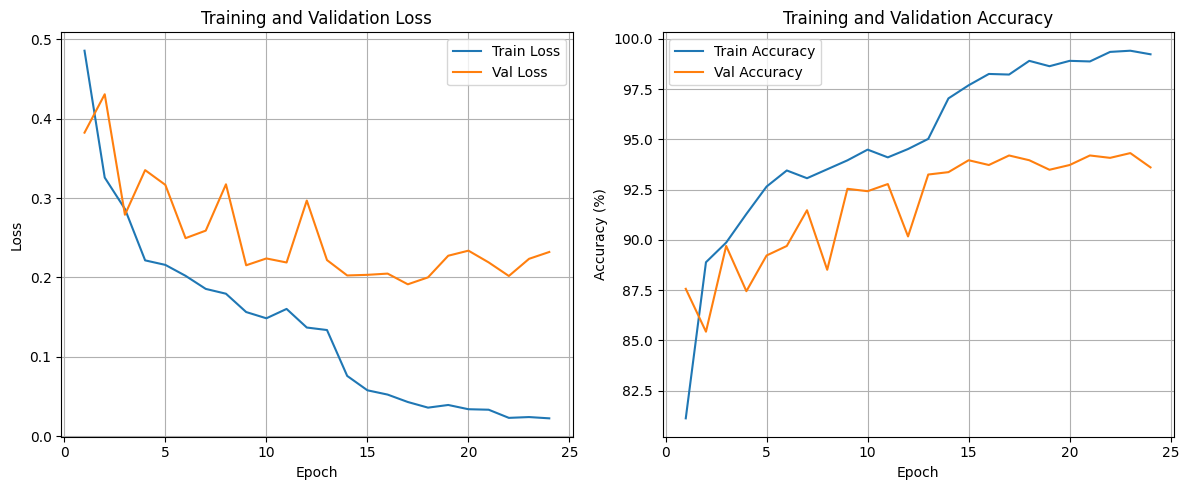


Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.97      0.95      0.96       216
diabetic_retinopathy       0.99      0.99      0.99       188
            glaucoma       0.90      0.92      0.91       211
              normal       0.91      0.90      0.91       229

            accuracy                           0.94       844
           macro avg       0.94      0.94      0.94       844
        weighted avg       0.94      0.94      0.94       844



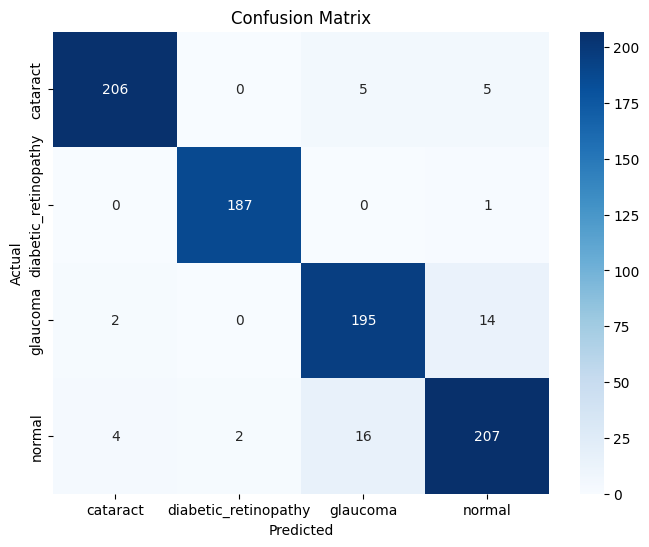

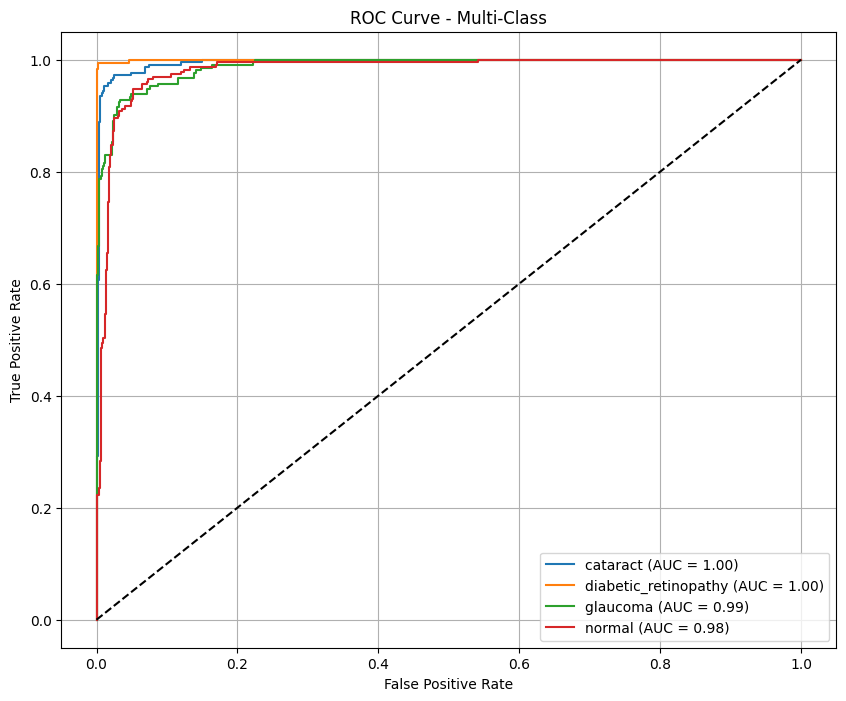

Predicted Class: cataract

=== Final Results ===
Final Training Accuracy: 99.23%
Final Validation Accuracy: 93.60%
Test Accuracy: 94.19%
Final AUC Score (Training+Validation): 0.9913
Test AUC Score: 0.9913

Class-wise AUC Scores:
cataract: 0.9953
diabetic_retinopathy: 0.9997
glaucoma: 0.9880
normal: 0.9820

Confusion Matrix:
 [[206   0   5   5]
 [  0 187   0   1]
 [  2   0 195  14]
 [  4   2  16 207]]

Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.97      0.95      0.96       216
diabetic_retinopathy       0.99      0.99      0.99       188
            glaucoma       0.90      0.92      0.91       211
              normal       0.91      0.90      0.91       229

            accuracy                           0.94       844
           macro avg       0.94      0.94      0.94       844
        weighted avg       0.94      0.94      0.94       844



In [6]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Stronger Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load DeiT Tiny Model with Stronger Dropout
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names), drop_rate=0.2)
model.to(device)

# Loss & Optimizer with Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Metrics
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training with Early Stopping
def train_model(model, train_loader, val_loader, epochs=50, patience=7):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_correct, val_total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_epoch_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train
train_model(model, train_loader, val_loader, epochs=50, patience=7)

# Load best model with weights_only=True
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
test_acc = accuracy_score(y_true, y_pred) * 100
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

final_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
test_auc = final_auc

# Single Image Prediction
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Final Results
class_report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("\n=== Final Results ===")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final AUC Score (Training+Validation): {final_auc:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClass-wise AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

Epoch 1/60 - Train Loss: 0.7991 - Train Acc: 76.16% - Val Loss: 0.6553 - Val Acc: 83.29%
Epoch 2/60 - Train Loss: 0.6609 - Train Acc: 84.38% - Val Loss: 0.6399 - Val Acc: 85.78%
Epoch 3/60 - Train Loss: 0.6015 - Train Acc: 87.04% - Val Loss: 0.6119 - Val Acc: 86.61%
Epoch 4/60 - Train Loss: 0.5842 - Train Acc: 87.82% - Val Loss: 0.6166 - Val Acc: 85.19%
Epoch 5/60 - Train Loss: 0.5672 - Train Acc: 89.12% - Val Loss: 0.5954 - Val Acc: 86.73%
Epoch 6/60 - Train Loss: 0.5520 - Train Acc: 89.65% - Val Loss: 0.5891 - Val Acc: 87.44%
Epoch 7/60 - Train Loss: 0.5464 - Train Acc: 90.04% - Val Loss: 0.5324 - Val Acc: 89.93%
Epoch 8/60 - Train Loss: 0.5256 - Train Acc: 91.19% - Val Loss: 0.5721 - Val Acc: 88.03%
Epoch 9/60 - Train Loss: 0.5273 - Train Acc: 91.05% - Val Loss: 0.5786 - Val Acc: 86.85%
Epoch 10/60 - Train Loss: 0.5148 - Train Acc: 91.58% - Val Loss: 0.5735 - Val Acc: 88.51%
Epoch 11/60 - Train Loss: 0.5264 - Train Acc: 90.87% - Val Loss: 0.5594 - Val Acc: 88.27%
Epoch 12/60 - Train

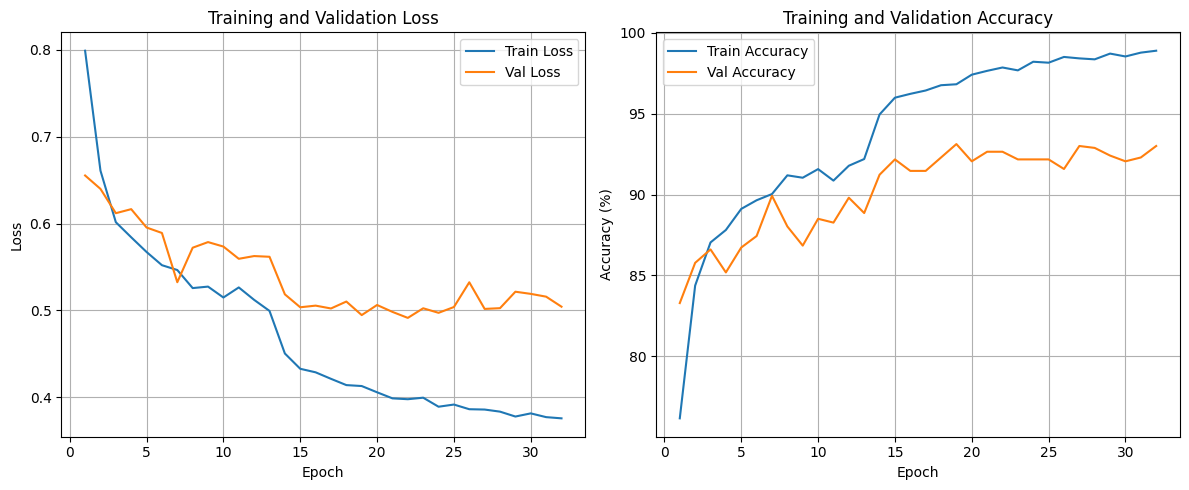


Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.94      0.94      0.94       201
diabetic_retinopathy       0.99      0.99      0.99       203
            glaucoma       0.89      0.88      0.88       224
              normal       0.88      0.90      0.89       216

            accuracy                           0.92       844
           macro avg       0.92      0.92      0.92       844
        weighted avg       0.92      0.92      0.92       844



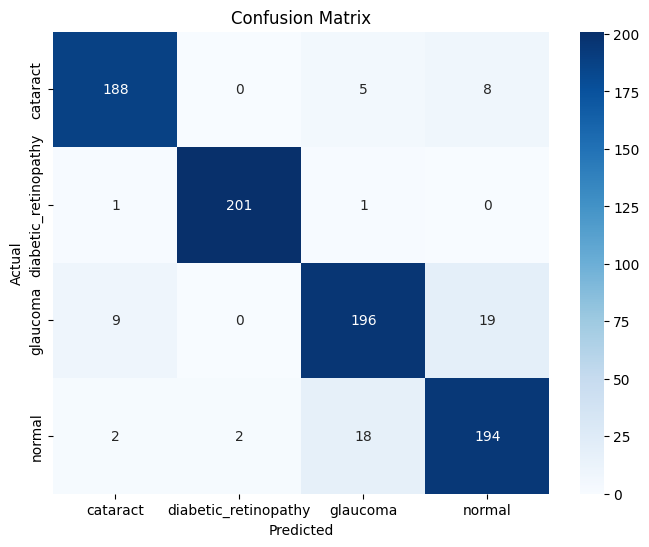

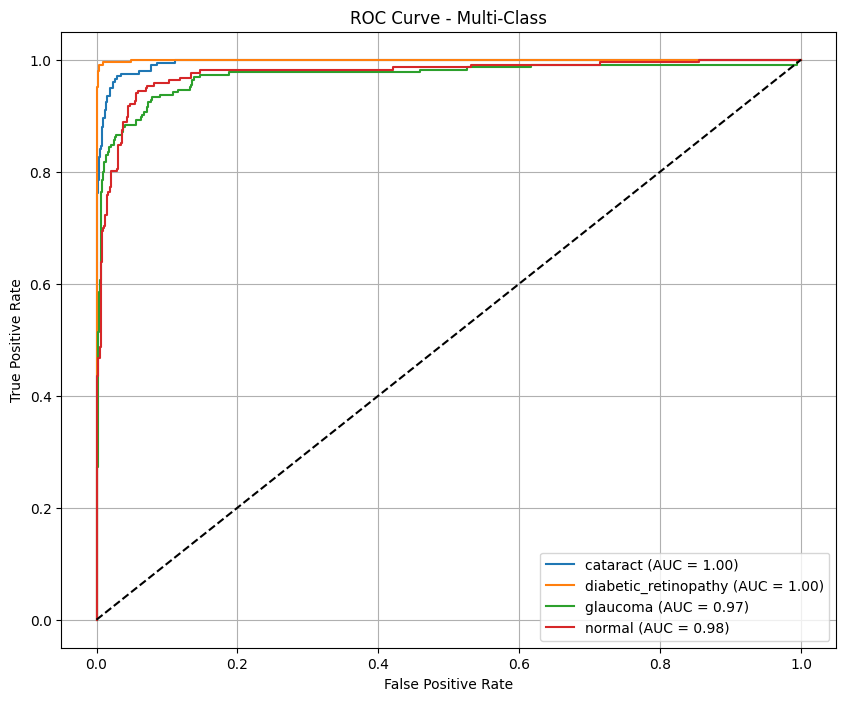

Predicted Class: cataract

=== Final Results ===
Final Training Accuracy: 98.90%
Final Validation Accuracy: 93.01%
Test Accuracy: 92.30%
Final AUC Score (Training+Validation): 0.9854
Test AUC Score: 0.9854

Class-wise AUC Scores:
cataract: 0.9958
diabetic_retinopathy: 0.9996
glaucoma: 0.9708
normal: 0.9754

Confusion Matrix:
 [[188   0   5   8]
 [  1 201   1   0]
 [  9   0 196  19]
 [  2   2  18 194]]

Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.94      0.94      0.94       201
diabetic_retinopathy       0.99      0.99      0.99       203
            glaucoma       0.89      0.88      0.88       224
              normal       0.88      0.90      0.89       216

            accuracy                           0.92       844
           macro avg       0.92      0.92      0.92       844
        weighted avg       0.92      0.92      0.92       844



In [7]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Stronger Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

# Load DeiT Tiny Model with Stronger Dropout
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names), drop_rate=0.3)
model.to(device)

# Loss & Optimizer with Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Metrics
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training with Early Stopping
def train_model(model, train_loader, val_loader, epochs=60, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_correct, val_total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_epoch_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train
train_model(model, train_loader, val_loader, epochs=60, patience=10)

# Load best model
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
test_acc = accuracy_score(y_true, y_pred) * 100
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

final_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
test_auc = final_auc

# Single Image Prediction
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Final Results
print("\n=== Final Results ===")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final AUC Score (Training+Validation): {final_auc:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClass-wise AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

Epoch 1/30 - Train Loss: 0.4959 - Train Acc: 81.03% - Val Loss: 0.3573 - Val Acc: 87.44%
Epoch 2/30 - Train Loss: 0.2994 - Train Acc: 88.79% - Val Loss: 0.2678 - Val Acc: 89.34%
Epoch 3/30 - Train Loss: 0.2570 - Train Acc: 90.57% - Val Loss: 0.2665 - Val Acc: 91.47%
Epoch 4/30 - Train Loss: 0.2298 - Train Acc: 91.55% - Val Loss: 0.2434 - Val Acc: 91.71%
Epoch 5/30 - Train Loss: 0.1934 - Train Acc: 92.71% - Val Loss: 0.3161 - Val Acc: 88.74%
Epoch 6/30 - Train Loss: 0.1837 - Train Acc: 93.24% - Val Loss: 0.2438 - Val Acc: 92.06%
Epoch 7/30 - Train Loss: 0.1701 - Train Acc: 93.89% - Val Loss: 0.2112 - Val Acc: 92.42%
Epoch 8/30 - Train Loss: 0.1621 - Train Acc: 94.25% - Val Loss: 0.2151 - Val Acc: 92.30%
Epoch 9/30 - Train Loss: 0.1297 - Train Acc: 95.23% - Val Loss: 0.2413 - Val Acc: 92.54%
Epoch 10/30 - Train Loss: 0.1282 - Train Acc: 95.38% - Val Loss: 0.2554 - Val Acc: 91.00%
Epoch 11/30 - Train Loss: 0.1174 - Train Acc: 95.88% - Val Loss: 0.2198 - Val Acc: 92.18%
Epoch 12/30 - Train

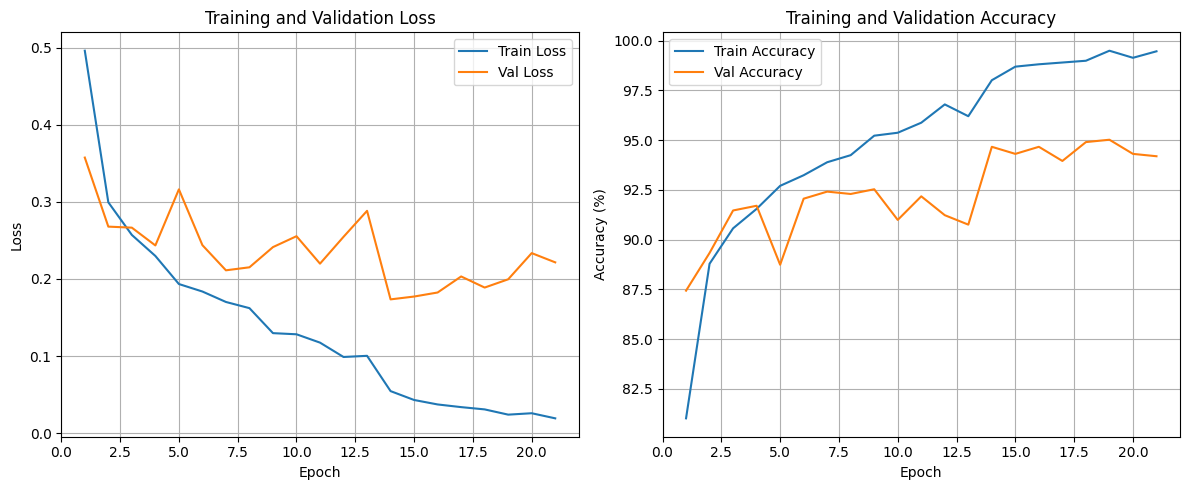


Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.94      0.96      0.95       205
diabetic_retinopathy       1.00      1.00      1.00       230
            glaucoma       0.90      0.93      0.92       189
              normal       0.94      0.90      0.92       220

            accuracy                           0.95       844
           macro avg       0.95      0.95      0.95       844
        weighted avg       0.95      0.95      0.95       844



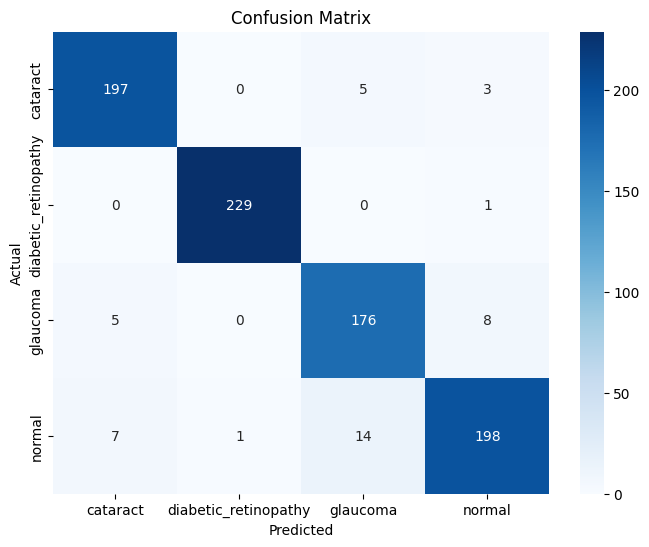

NameError: name 'hellowithyourextraditionalsubaverageallrighty' is not defined

In [8]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load DeiT Tiny Model
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names), drop_rate=0.2)
model.to(device)

# Loss & Optimizer with Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Metrics
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training with Early Stopping
def train_model(model, train_loader, val_loader, epochs=30, patience=7):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_correct, val_total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_epoch_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train
train_model(model, train_loader, val_loader, epochs=30, patience=7)

# Load best model
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
test_acc = accuracy_score(y_true, y_pred) * 100
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)
fpr, tpr,hellowithyourextraditionalsubaverageallrighty
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

final_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
test_auc = final_auc

# Single Image Prediction
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Final Results
print("\n=== Final Results ===")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final AUC Score (Training+Validation): {final_auc:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClass-wise AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

Epoch 1/30 - Train Loss: 0.4907 - Train Acc: 81.89% - Val Loss: 0.4181 - Val Acc: 84.60%
Epoch 2/30 - Train Loss: 0.3102 - Train Acc: 88.17% - Val Loss: 0.2635 - Val Acc: 89.34%
Epoch 3/30 - Train Loss: 0.2528 - Train Acc: 90.84% - Val Loss: 0.2726 - Val Acc: 88.39%
Epoch 4/30 - Train Loss: 0.2369 - Train Acc: 91.43% - Val Loss: 0.2159 - Val Acc: 92.77%
Epoch 5/30 - Train Loss: 0.1949 - Train Acc: 93.24% - Val Loss: 0.2448 - Val Acc: 92.06%
Epoch 6/30 - Train Loss: 0.1923 - Train Acc: 92.80% - Val Loss: 0.2070 - Val Acc: 91.59%
Epoch 7/30 - Train Loss: 0.1649 - Train Acc: 93.92% - Val Loss: 0.3303 - Val Acc: 86.37%
Epoch 8/30 - Train Loss: 0.1490 - Train Acc: 94.43% - Val Loss: 0.2197 - Val Acc: 90.52%
Epoch 9/30 - Train Loss: 0.1298 - Train Acc: 95.29% - Val Loss: 0.2520 - Val Acc: 89.93%
Epoch 10/30 - Train Loss: 0.1309 - Train Acc: 95.05% - Val Loss: 0.2190 - Val Acc: 90.76%
Epoch 11/30 - Train Loss: 0.1214 - Train Acc: 95.58% - Val Loss: 0.2069 - Val Acc: 92.42%
Epoch 12/30 - Train

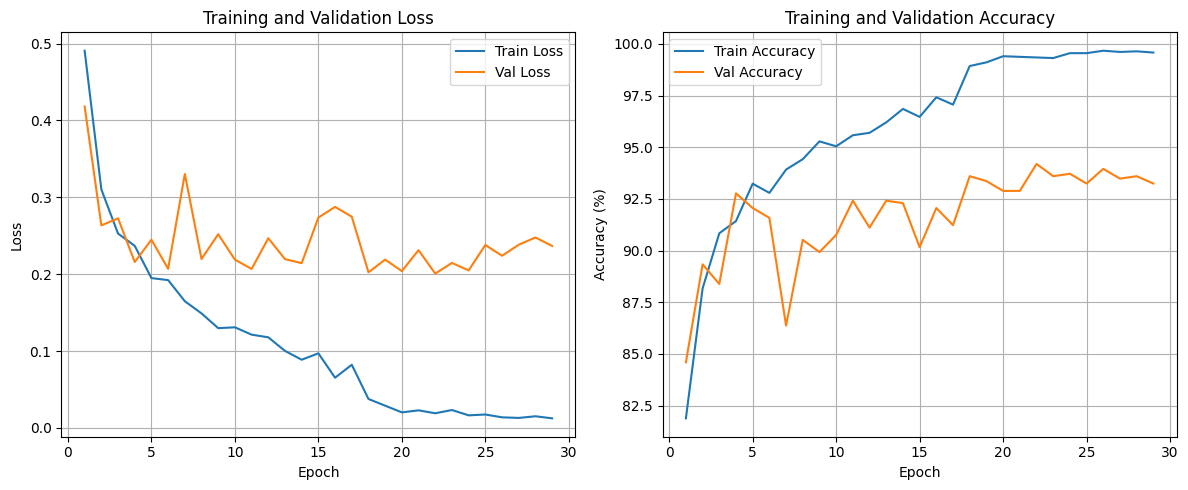


Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.97      0.96      0.96       205
diabetic_retinopathy       0.98      0.99      0.99       219
            glaucoma       0.91      0.88      0.90       191
              normal       0.90      0.91      0.90       229

            accuracy                           0.94       844
           macro avg       0.94      0.94      0.94       844
        weighted avg       0.94      0.94      0.94       844



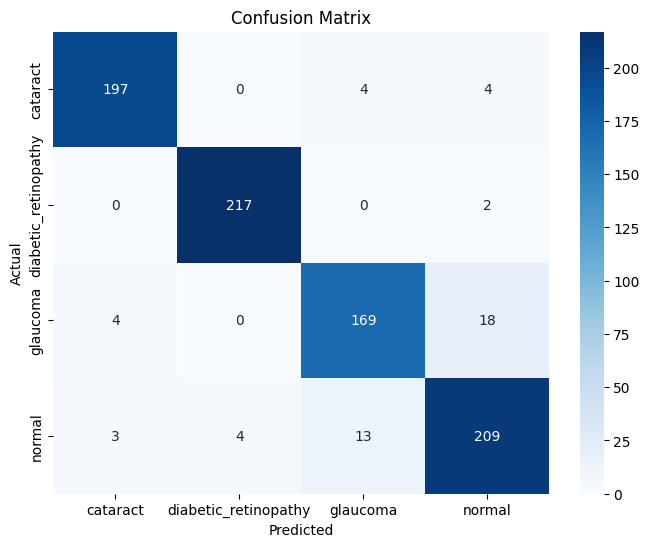

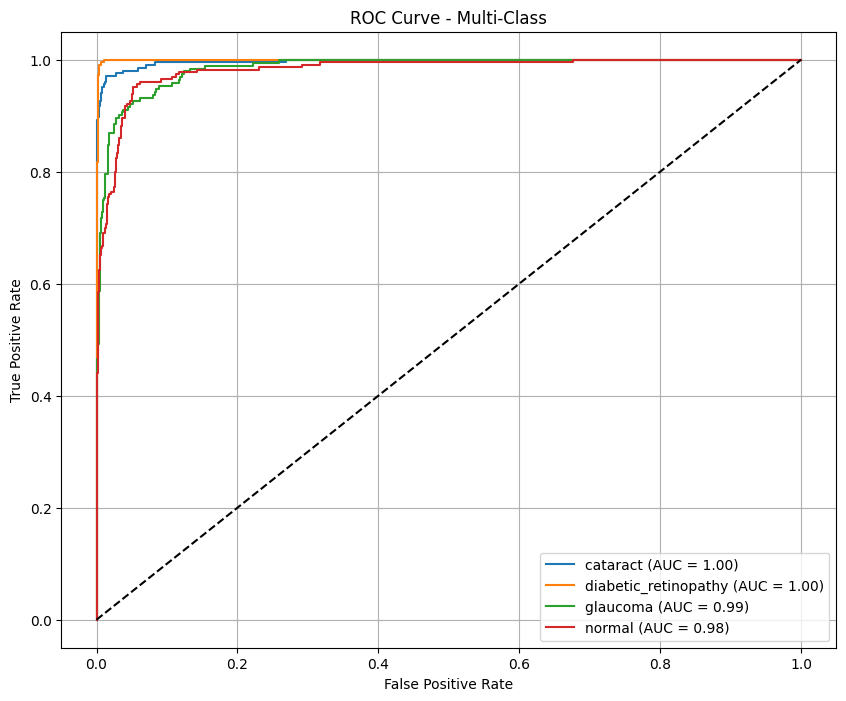

Predicted Class: cataract

=== Final Results ===
Final Training Accuracy: 99.58%
Final Validation Accuracy: 93.25%
Test Accuracy: 93.84%
Final AUC Score (Training+Validation): 0.9910
Test AUC Score: 0.9910

Class-wise AUC Scores:
cataract: 0.9968
diabetic_retinopathy: 0.9996
glaucoma: 0.9858
normal: 0.9819

Confusion Matrix:
 [[197   0   4   4]
 [  0 217   0   2]
 [  4   0 169  18]
 [  3   4  13 209]]

Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.97      0.96      0.96       205
diabetic_retinopathy       0.98      0.99      0.99       219
            glaucoma       0.91      0.88      0.90       191
              normal       0.90      0.91      0.90       229

            accuracy                           0.94       844
           macro avg       0.94      0.94      0.94       844
        weighted avg       0.94      0.94      0.94       844



In [9]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load DeiT Tiny Model
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names), drop_rate=0.2)
model.to(device)

# Loss & Optimizer with Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Metrics
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training with Early Stopping
def train_model(model, train_loader, val_loader, epochs=30, patience=7):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_correct, val_total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_epoch_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train
train_model(model, train_loader, val_loader, epochs=30, patience=7)

# Load best model
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
test_acc = accuracy_score(y_true, y_pred) * 100
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)
fpr, tpr = {}, {}  # Fixed line
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

final_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
test_auc = final_auc

# Single Image Prediction
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Final Results
print("\n=== Final Results ===")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final AUC Score (Training+Validation): {final_auc:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClass-wise AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

In [11]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load DeiT Tiny Model
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names), drop_rate=0.2)
model.to(device)

# Loss & Optimizer with Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Metrics
train_losses, train_accuracies, val_losses, val_accuracies = [], [], []

# Training with Early Stopping
def train_model(model, train_loader, val_loader, epochs=40, patience=7):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_correct, val_total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_epoch_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train
train_model(model, train_loader, val_loader, epochs=40, patience=7)

# Load best model
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
test_acc = accuracy_score(y_true, y_pred) * 100
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)
fpr, tpr = {}, {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

final_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
test_auc = final_auc

# Single Image Prediction
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Final Results
print("\n=== Final Results ===")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final AUC Score (Training+Validation): {final_auc:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClass-wise AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

ValueError: not enough values to unpack (expected 4, got 3)

In [12]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

download_file('/kaggle/working/', 'March_05_DeiT')

/kaggle/working/March_05_DeiT.zip

Epoch 1/40 - Train Loss: 0.6348 - Train Acc: 79.57% - Val Loss: 0.4557 - Val Acc: 89.22%
Epoch 2/40 - Train Loss: 0.4326 - Train Acc: 89.80% - Val Loss: 0.4135 - Val Acc: 90.76%
Epoch 3/40 - Train Loss: 0.4218 - Train Acc: 90.34% - Val Loss: 0.4331 - Val Acc: 90.40%
Epoch 4/40 - Train Loss: 0.3928 - Train Acc: 91.70% - Val Loss: 0.3967 - Val Acc: 91.23%
Epoch 5/40 - Train Loss: 0.3650 - Train Acc: 92.80% - Val Loss: 0.4616 - Val Acc: 89.22%
Epoch 6/40 - Train Loss: 0.3377 - Train Acc: 94.16% - Val Loss: 0.4090 - Val Acc: 91.59%
Epoch 7/40 - Train Loss: 0.3387 - Train Acc: 94.07% - Val Loss: 0.3788 - Val Acc: 91.47%
Epoch 8/40 - Train Loss: 0.3268 - Train Acc: 94.34% - Val Loss: 0.3965 - Val Acc: 92.18%
Epoch 9/40 - Train Loss: 0.3170 - Train Acc: 95.08% - Val Loss: 0.3692 - Val Acc: 91.82%
Epoch 10/40 - Train Loss: 0.2950 - Train Acc: 95.85% - Val Loss: 0.4010 - Val Acc: 91.71%
Epoch 11/40 - Train Loss: 0.2958 - Train Acc: 96.12% - Val Loss: 0.3804 - Val Acc: 92.54%
Epoch 12/40 - Train

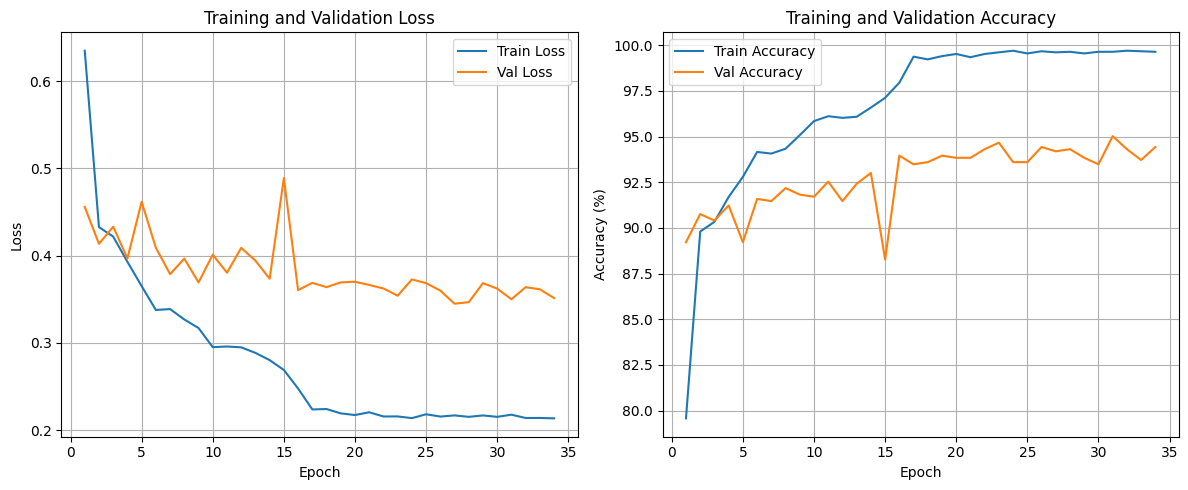


Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.97      0.96      0.97       224
diabetic_retinopathy       0.98      0.99      0.99       198
            glaucoma       0.91      0.87      0.89       203
              normal       0.89      0.92      0.90       219

            accuracy                           0.94       844
           macro avg       0.94      0.94      0.94       844
        weighted avg       0.94      0.94      0.94       844



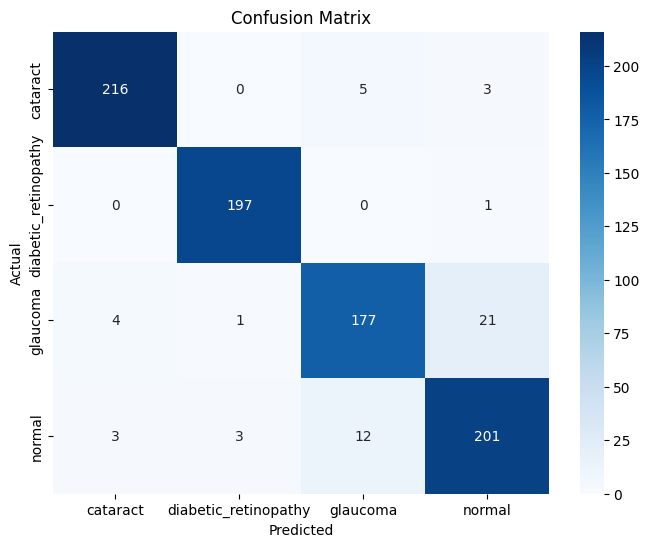

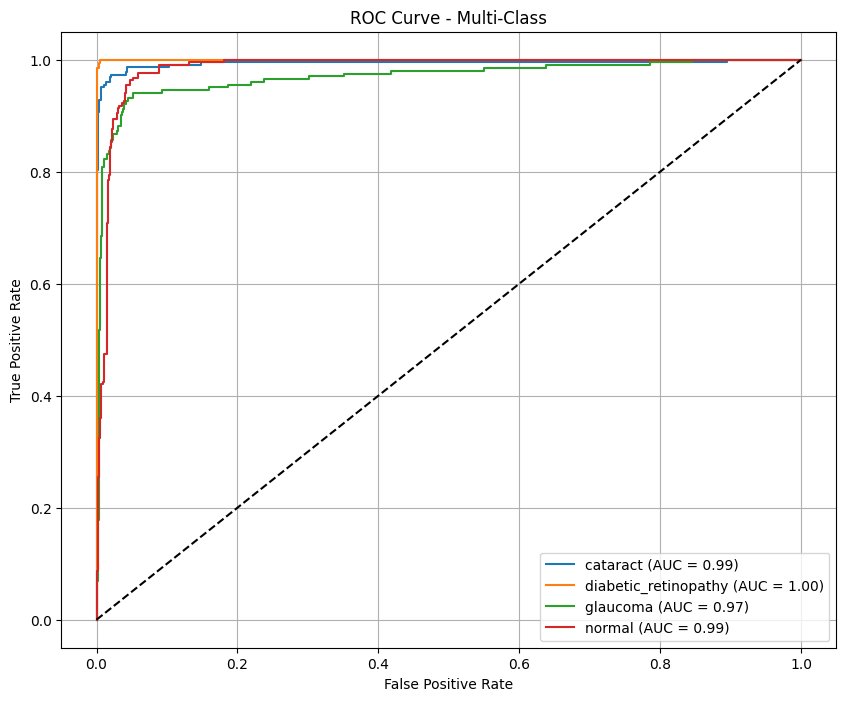

Predicted Class: cataract

=== Final Results ===
Final Training Accuracy: 99.64%
Final Validation Accuracy: 94.43%
Test Accuracy: 93.72%
Final AUC Score (Training+Validation): 0.9871
Test AUC Score: 0.9871

Class-wise AUC Scores:
cataract: 0.9935
diabetic_retinopathy: 0.9999
glaucoma: 0.9695
normal: 0.9855

Confusion Matrix:
 [[216   0   5   3]
 [  0 197   0   1]
 [  4   1 177  21]
 [  3   3  12 201]]

Classification Report (Test Set):
                       precision    recall  f1-score   support

            cataract       0.97      0.96      0.97       224
diabetic_retinopathy       0.98      0.99      0.99       198
            glaucoma       0.91      0.87      0.89       203
              normal       0.89      0.92      0.90       219

            accuracy                           0.94       844
           macro avg       0.94      0.94      0.94       844
        weighted avg       0.94      0.94      0.94       844



In [13]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load DeiT Tiny Model
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names), drop_rate=0.2)
model.to(device)

# Loss & Optimizer with Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Added label smoothing
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Metrics (Fixed unpacking error)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training with Early Stopping
def train_model(model, train_loader, val_loader, epochs=40, patience=7):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_correct, val_total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_epoch_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train
train_model(model, train_loader, val_loader, epochs=40, patience=7)

# Load best model
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
test_acc = accuracy_score(y_true, y_pred) * 100
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores = np.array(y_scores)
fpr, tpr = {}, {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend()
plt.grid(True)
plt.show()

final_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
test_auc = final_auc

# Single Image Prediction
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.argmax(1).item()
    print(f"Predicted Class: {class_names[predicted_class]}")

test_image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg"
predict_image(test_image_path, model, class_names)

# Final Results
print("\n=== Final Results ===")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final AUC Score (Training+Validation): {final_auc:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClass-wise AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

In [14]:
download_file('/kaggle/working/best_model.pt', 'March_05_DeiT_final')

/kaggle/working/March_05_DeiT_final.zip